# INIT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../../../../deconv_py/')
sys.path.append('../../../infras/cellMix/')
sys.path.append('../../../infras/cytof_data/')
sys.path.append('../../../infras/ctpnet/')
sys.path.append('../../../infras/')
sys.path.append('../../../infras/dashboards/')
sys.path.append('../../../experiments/')
sys.path.append('../../../experiments/pipeline/')
sys.path.append('../../../preprocess/intra_variance/')
sys.path.append('../../../models/cell_proportions/')
sys.path.append('../../../measures/cell_proportions_measures/')
sys.path.append('../../../preprocess/cell_specifics/')
sys.path.append('../../../preprocess/data_sets/')


In [3]:
from data_factory import DataFactory
from global_utils import GlobalUtils
from cytof_cell_count_infra import CytofCellCountInfra
from cell_proportions_experiments import  CellProportionsExperiments
import exploration_cytof_plots as cytof_plots

from pp_entropy_based import PpEntropyBased
from pp_dep_de_based import  PpDepDeBased
from cell_proportions_measure import CellProportionsMeasure
from pp_clean_high_intra_var import PpCleanHighIntraVar
from pp_clean_irrelevant_proteins import PpCleanIrrelevantProteins
from pp_empty import PpEmpty
from pp_entropy_based_only_largest import PpEntropyBasedOnlyLargest
from aggregate_intra_variance import AggregateIntraVariance
from pipeline_deconv import PipelineDeconv
from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins
from deconv_py.preprocess.cell_specifics.pp_svm_signature import PpSvmSignature
from deconv_py.preprocess.cell_specifics.pp_entropy_based_totel_sum import PpEntropyBasedTotelSum
from deconv_py.preprocess.cell_specifics.pp_floor_under_quantile import PpFloorUnderQuantile
from pick_data_set import PickDataSet
# from deconvolution_results_plots import DeconvolutionResultsPlots

from basic import BasicDeconv
from regression import RegressionDeconv
from generalized_estimating_equations import GeneralizedEstimatingEquations
from robust_linear_model import RobustLinearModel
from deconvolution_model import DeconvolutionModel
from sklearn import linear_model


from pp_keep_specific_cells  import  PpKeepSpecificCells
from pp_agg_to_specific_cells import PpAggToSpecificCells

# from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader
from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation
from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot
from cellMix_coordinator import CellMixCoordinator

from infras.ctpnet.ctpnet_coordinator import CtpNetCoordinator


import pandas as pd
import numpy as np
from functools import partial
import multiprocessing
from sklearn import pipeline
import itertools
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.optimize import minimize
import scipy.optimize
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import os
import pickle as pkl 
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import statsmodels.api as sm
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
import mygene
import math
from scipy.stats import gaussian_kde


%connect_info

{
  "shell_port": 51506,
  "iopub_port": 51507,
  "stdin_port": 51508,
  "control_port": 51509,
  "hb_port": 51510,
  "ip": "127.0.0.1",
  "key": "5c7d1621-a735c4af706960fe9d04e4a4",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-7c3c06df-9f29-45d4-a78f-d376bc77a913.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


# build_data_sets

## read protein data

LFQ: rel. quantification – for same protein across different samples

iBAQ: orthogonal comparison – for different proteins in the same sample

Intensity: supposed to be both

In [4]:
data_factory = DataFactory()
A_all_vs,B_all_vs = data_factory.load_IBD_all_vs("Intensity",index_func=lambda x:x.split(";")[0],log2_transformation=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  


## read mrna data

we start with mapping the cells annotations from the MassSpec to mRNA : 

In [5]:
MASS_CELL_NAMES_TO_HAMRNA_CELL_MAPPING =  {'BCellmemory': 'Bmemory_not_2',
                                    'BCellnaive' : None,
                                    'BCellplasma' : None,
                                    'CD4TCellmTregs' : None,
                                    'CD4TCellnaive':'T4naive_not_4',
                                    'CD4TCellnTregs':None,
                                    'CD4TCellTcm' : 'T4cm_not_5' ,
                                    'CD4TCellTem' : None,
                                    'CD4TCellTemra' :None,
                                    'CD4TCellTh1':None,
                                    'CD4TCellTh17':None,
                                    'CD4TCellTh2':None,
                                    'CD8TCellnaive':None,
                                    'CD8TCellTcm' : None,
                                    'CD8TCellTem' : None ,
                                    'CD8TCellTemra' : None,
                                    'DendriticCD1c' : None,
                                    'DendriticCD304' : None,
                                    'Erythrocytes' : None,
                                    'Monocytesclassical': 'MOclassical_not_3' ,
                                    'Monocytesintermediate' : None,
                                    'Monocytesnonclassical': None,
                                    'NKCellsCD56bright' : None,
                                    'NKCellsCD56dim': None,
                                    'Thrombocytes' : None,
                                    'Granulocyteseosinophils' : None,
                                    'GranulocytesBasophil' : None}


In [6]:
rna_blood_cell_df = pd.read_excel("../../../data/gene_expression/Rieckmann et al - tableS6_RNAseq.transcriptome.data.of.immune.cell.types.xlsx", encoding= 'unicode_escape')


In [7]:
rna_blood_cell_df =rna_blood_cell_df.loc[~rna_blood_cell_df[["Gene name"]].duplicated()]
rna_blood_cell_df = rna_blood_cell_df.set_index("Gene name")

cells_list = ['Intensity NOT_BCellmemory', 'Intensity NOT_BCellnaive',
       'Intensity NOT_BCellplasma', 'Intensity NOT_CD4TCellTcm',
       'Intensity NOT_CD4TCellTem', 'Intensity NOT_CD4TCellTemra',
       'Intensity NOT_CD4TCellnTregs', 'Intensity NOT_CD4TCellnaive',
       'Intensity NOT_CD8TCellTem', 'Intensity NOT_CD8TCellTemra',
       'Intensity NOT_CD8TCellnaive', 'Intensity NOT_DendriticCD1c',
       'Intensity NOT_DendriticCD304', 'Intensity NOT_Monocytesclassical',
       'Intensity NOT_Monocytesintermediate',
       'Intensity NOT_Monocytesnonclassical',
       'Intensity NOT_NKCellsCD56bright', 'Intensity NOT_NKCellsCD56dim']
cells_name_mapping = MASS_CELL_NAMES_TO_HAMRNA_CELL_MAPPING

run_time_cells_to_Mass_cells_mapping = GlobalUtils.get_corospanding_cell_map_from_lists(cells_list,cells_name_mapping.keys())
ctpnet_to_run_time_cells_mapping = {cells_name_mapping[run_time_cells_to_Mass_cells_mapping[run_time_cell]] : run_time_cell for run_time_cell in cells_list }
ctpnet_to_run_time_cells_mapping = {k:v for k,v in ctpnet_to_run_time_cells_mapping.items() if not k is None}

In [8]:
gene_df_sig_cells = rna_blood_cell_df[[c for c in ctpnet_to_run_time_cells_mapping.keys() if c is not None]].rename(columns = ctpnet_to_run_time_cells_mapping)

## multiply by mRNA to proteins ratio

We took the learned ratios between mRNA to MassSpec from:  
"Wilhelm, M., Schlegl, J., Hahne, H. et al. Mass-spectrometry-based draft of the human proteome. Nature 509, 582–587 (2014)"  

The ratio is a log ratio so we convert as needed 

In [9]:
accs_ratio = pd.read_excel(r'protein_to_gene_ratio_after_mapping.xlsx').set_index('Accessions')

In [10]:
_mutual_genes = gene_df_sig_cells.index.intersection(accs_ratio.index).intersection(A_all_vs.index.get_level_values(1))

gene_df_sig_cells_mutual = gene_df_sig_cells.loc[_mutual_genes].copy(deep=True)
accs_ratio_mutual_genes = accs_ratio.loc[_mutual_genes]

In [11]:
mrna_data_infer_to_protein = np.power(gene_df_sig_cells_mutual,10)*np.power(accs_ratio_mutual_genes.values,10)
# mrna_data_infer_to_protein = np.power(gene_df_sig_cells_mutual,10)

In [26]:
A_all_vs.shape

(5338, 92)

# compare sets

In [12]:
agg_iv,pp_irl_prot  = AggregateIntraVariance(),PpCleanIrrelevantProteins()

In [13]:
def return_mutual_df(A_all_vs,prot_from_gene_infer):
    A_for_compr = A_all_vs.copy(deep=True)
    A_for_compr.index = A_for_compr.index.droplevel(0)

    _mutual_a_ref_genes = A_for_compr.index.intersection(prot_from_gene_infer.index)
    _mutual_a_ref_cells = A_for_compr.columns.intersection(prot_from_gene_infer.columns)

    A_for_compr = A_for_compr.loc[_mutual_a_ref_genes]
    prot_from_gene_infer_for_comp = prot_from_gene_infer.loc[_mutual_a_ref_genes]

    A_for_compr = A_for_compr[_mutual_a_ref_cells]
    prot_from_gene_infer_for_comp = prot_from_gene_infer_for_comp[_mutual_a_ref_cells]

    A_for_compr = A_for_compr[~A_for_compr.index.duplicated()]
    prot_from_gene_infer_for_comp = prot_from_gene_infer_for_comp[~prot_from_gene_infer_for_comp.index.duplicated()]
    return A_for_compr,prot_from_gene_infer_for_comp

In [14]:
def plot_proteins_vs_mrna_per_mixtures(proteins_df,mrna_df,percantile_to_take = (1,0),lims = [[-1,30],[4,21]],as_log=True,correlation_type =  "spearman",specific_mixture = None):
    if type(proteins_df.index) is pd.MultiIndex : 
        proteins_df.index = proteins_df.index.droplevel(0)

    mutual_mixures = mrna_df.columns.intersection(proteins_df.columns)
    #     mutual_mixures = mutual_mixures if specific_mixture is None else [specific_mixture]

    _fig_size = (15,45) if specific_mixture is None else (10,7)
    n_plots = math.ceil(len(mutual_mixures)/2) if specific_mixture is None else 1
    n_rows = 2 if specific_mixture is None else 1

    fig, axs = plt.subplots(n_plots,n_rows,figsize=_fig_size)

    _mixture_iter = zip(mutual_mixures,axs.reshape(-1)) if specific_mixture is None else [(specific_mixture,axs)]

    for mixture,ax in _mixture_iter :
        protein_expression = proteins_df[mixture]
        mrna_expression = mrna_df[mixture]

        exp_robust = protein_expression[protein_expression <= protein_expression.quantile(percantile_to_take[0])].dropna().index
        B_robust = mrna_expression[mrna_expression <= mrna_expression.quantile(percantile_to_take[0])].dropna().index

        _exp_robust = protein_expression[protein_expression >= protein_expression.quantile(percantile_to_take[1])].dropna().index
        _B_robust = mrna_expression[mrna_expression >= mrna_expression.quantile(percantile_to_take[1])].dropna().index
        mutual_robust = exp_robust.intersection(B_robust).intersection(_exp_robust).intersection(_B_robust)

        protein_expression = protein_expression.loc[mutual_robust]
        mrna_expression = mrna_expression.loc[mutual_robust]

        protein_expression = protein_expression.dropna()
        mrna_expression = mrna_expression.dropna()

        protein_expression = protein_expression[~protein_expression.index.duplicated(keep="first")]
        mrna_expression = mrna_expression[~mrna_expression.index.duplicated(keep="first")]

        mutual_not_none = protein_expression.index.intersection(mrna_expression.index).drop_duplicates().copy(deep=True)

        protein_expression = protein_expression.loc[mutual_not_none]
        mrna_expression = mrna_expression.loc[mutual_not_none]

        if as_log : 
            y = np.log(1+protein_expression)
            x = np.log(1+mrna_expression)
        else : 
            y = protein_expression
            x = mrna_expression

        correlation_with_out_zeros = np.round(protein_expression[x != 0].corr(mrna_expression[x != 0],method=correlation_type),3)
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        ax.scatter(x, y, c=z,s=100)
        ax.set_title(f"{mixture},correlation : {correlation_with_out_zeros}")
        ax.set_xlabel("mRNA")
        ax.set_ylabel("protein")

        if lims is not None : 
            ax.set_xlim(lims[0])
            ax.set_ylim(lims[1])
    plt.subplots_adjust(hspace=0.5)  

## compare all proteins to all genes 

### med value of genes

Here we took the median value of each protein (between Jan versions) and compare them to the adjusted mRNA values :

In [15]:
agg_iv = AggregateIntraVariance(how = 'median')
A_protein = agg_iv.transform([A_all_vs,None])[0]
# mrna_data_infer_to_protein

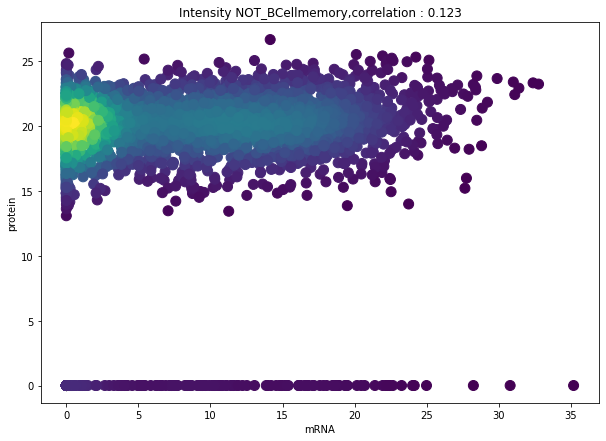

In [16]:
plot_proteins_vs_mrna_per_mixtures(A_protein,mrna_data_infer_to_protein,
                                   lims=None,
                                   percantile_to_take =(1,0),
                                   specific_mixture='Intensity NOT_BCellmemory')

### med values + taking only percantile 0.5 to 0.9 

Here we kept only high values (mostly remove zeros from proteins)

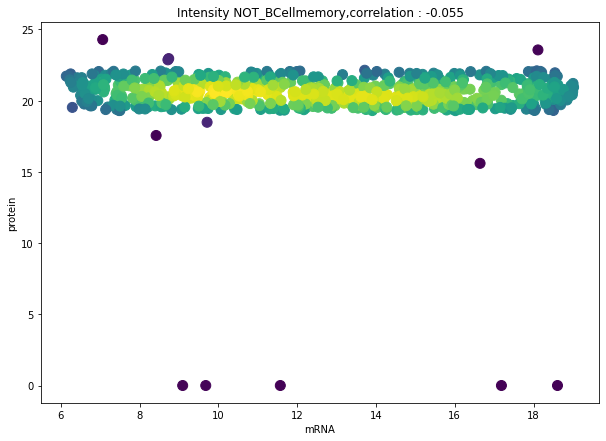

In [17]:
plot_proteins_vs_mrna_per_mixtures(A_protein,mrna_data_infer_to_protein,
                                   lims=None,
                                   percantile_to_take =(0.9,0.5),
                                   specific_mixture='Intensity NOT_BCellmemory')

### med values + taking only percantile 0.95 to 0.8

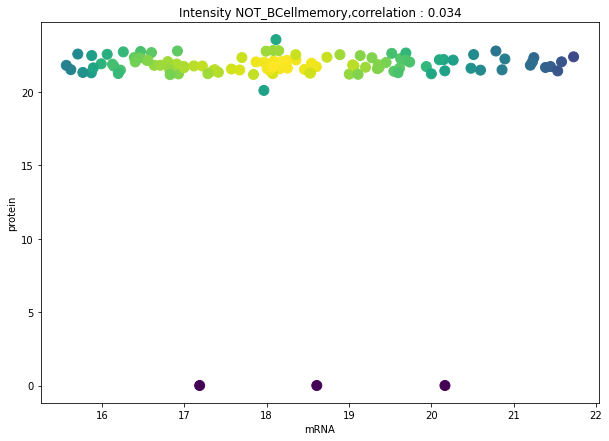

In [18]:
plot_proteins_vs_mrna_per_mixtures(A_protein,mrna_data_infer_to_protein,
                                   lims=None,
                                   percantile_to_take =(0.95,0.8),
                                   specific_mixture='Intensity NOT_BCellmemory')

### med values + taking only percantile 0.95 to 1

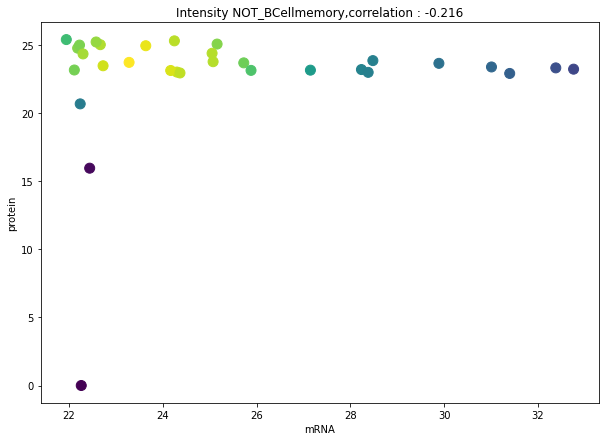

In [19]:
plot_proteins_vs_mrna_per_mixtures(A_protein,mrna_data_infer_to_protein,
                                   lims=None,
                                   percantile_to_take =(1,0.95),
                                   specific_mixture='Intensity NOT_BCellmemory')

## remove high STD proteins

Here we removed proteins we are "not sure about". aka - proteins where the std between versions is bigger then 0.8

In [20]:
agg_iv = AggregateIntraVariance(how = 'median')
A_protein_low_std = agg_iv.transform([A_all_vs,None])[0]

In [21]:
tmp = A_all_vs.copy(deep=True).T
tmp['V'] = tmp.index.map(lambda x:x.split('_0')[0])
A_protein_low_std = A_protein_low_std[((tmp.groupby('V').std()/tmp.groupby('V').mean()) > 0.8).T]

### med value of genes

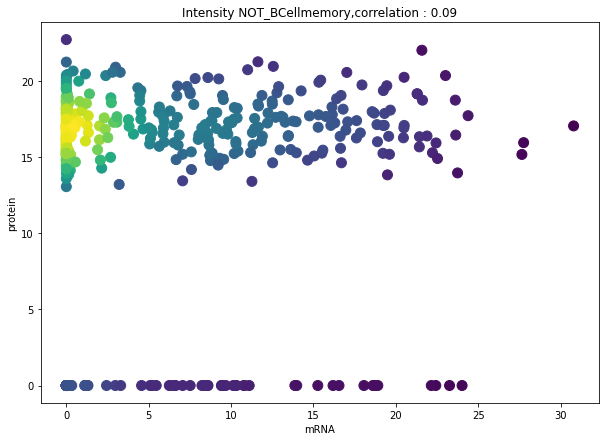

In [22]:
plot_proteins_vs_mrna_per_mixtures(A_protein_low_std,mrna_data_infer_to_protein,
                                   lims=None,
                                   percantile_to_take =(1,0),
                                   specific_mixture='Intensity NOT_BCellmemory')

### med values + taking only percantile 0.5 to 0.9 

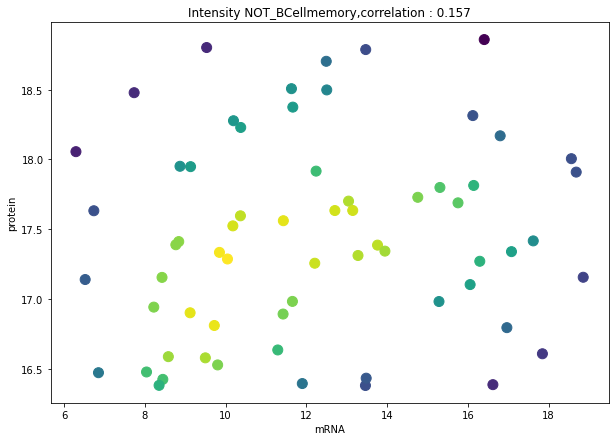

In [23]:
plot_proteins_vs_mrna_per_mixtures(A_protein_low_std,mrna_data_infer_to_protein,
                                   lims=None,
                                   percantile_to_take =(0.9,0.5),
                                   specific_mixture='Intensity NOT_BCellmemory')

### med values + taking only percantile 0.99 to 0.7

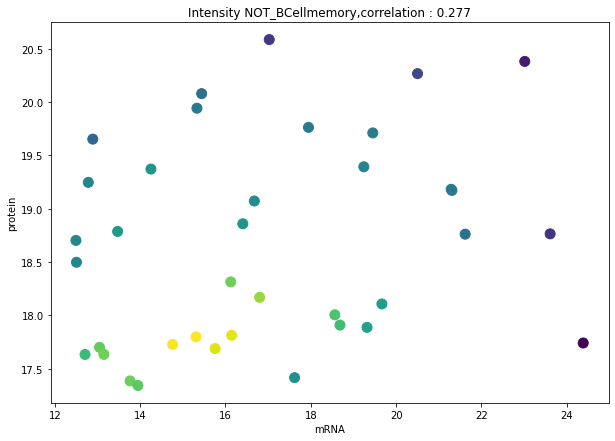

In [24]:
plot_proteins_vs_mrna_per_mixtures(A_protein_low_std,mrna_data_infer_to_protein,
                                   lims=None,
                                   percantile_to_take =(0.99,0.7),
                                   specific_mixture='Intensity NOT_BCellmemory')